What this notebook does:

Counts the number of words in each review related to 1) Coffee, 2) Food, 3) Sweets, and plots the distribution of these counts across all reviews. This is motivated by observation that different coffee-related terms (like expresso drinks, pour-overs, etc) are spread across different LDA topics. One reason could be that within individual reviews, only a small number of coffee drinks, savoury food items, or sweet items are mentioned.  As a result LDA would have a hard time associated many different types of coffee drinks, or food items with one another.  Couting occurences of these related terms can help to verify this.

Word2vec was used to identify words related to (express,coffee), (food, sandwich), or (dessert, cookies). To do this, a word2vec model was trained on the lemmatized review nouns.  Hierarchical clustering with complete linkage was used to group words with similar usage. For each pair, the words in the same cluster were identified, and the top 10 highest occuring words in that cluster were saved.  This resulted in 3 sets of words: the top 10 coffee related words, food related words, and sweet related words.  The number of reviews with 1 word, 2 words, 3 words, in each set was counted and plotted.

For each set of related terms, the fraction of reviews containing some number x of those terms decreased with increasing x. As expected, reviews do not contain many mentions of words with similar usage.

In [ ]:
#Step one directory up to access the yelp scraping function in the helper_functions module
import os
print(os.getcwd())
os.chdir('../')
os.getcwd()

In [2]:
import warnings

import gensim

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


In [3]:
topldawords = pd.read_csv('./LDAresults/ldatopwordsfor5topics.csv')
topldawords.head(5)

,ldatopic,word,probability,rank
0,0,chocolate,0.040577,1
1,0,tea,0.037534,2
2,0,cookie,0.031508,3
3,0,latte,0.024652,4
4,0,flavor,0.022728,5


In [4]:
#Reading in the sentences to train a word2vec model

warnings.filterwarnings("ignore")

class SentenceCorpus(object):

    def __init__(self, filename):
        self.filename = filename

    def __iter__(self):
        with open(self.filename, "r") as i:
            for line in i:
                tokens = line.strip().split()
                yield tokens

              
TEXT_FILE = './ProcessedData/reviewsentences.csv'
sentences = SentenceCorpus(TEXT_FILE)


In [5]:
model = gensim.models.Word2Vec(sentences, min_count=25, window=10, size=100,iter=100)

In [46]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
test =model.wv['latte'] 
test = np.array([test])

test1 =model.wv['cortado'] 
test1 = np.array([test1])
cosine_similarity(test,test1)


array([[0.5827512]], dtype=float32)

In [8]:
#Loading the previously lemmatized reviews (nouns only)
import csv 
with open('./LDAresults/lemmatized_reviews_nouns.csv', newline='') as csvfile: 
    dialect = csv.Sniffer().sniff(csvfile.read())
    csvfile.seek(0)
    reader = csv.reader(csvfile, dialect)
    rows = list(reader)
len(rows)

21594

In [9]:
reviews = [row[0].split(',') for row in rows if len(row)>0]
len(reviews)

21563

In [10]:
nouns = {}
for review in reviews:
    for noun in review:
        if noun not in nouns:
            nouns[noun] = 0
        nouns[noun] = nouns[noun] + 1

In [11]:
keys = model.wv.vocab.keys()

In [64]:
import numpy as np
print(len(keys))
keys1 = [key for key in keys if key in nouns]
#keys1 = ['latte','macchiato','cortado','coffee','cold_brew','sandwich','chicken','pizza']
print(len(keys1))
wvs = np.array([model.wv[key] for key in keys1])
#print(wvs[100])
#print(keys1[100])
#print(model.wv['price'])

3147
1989


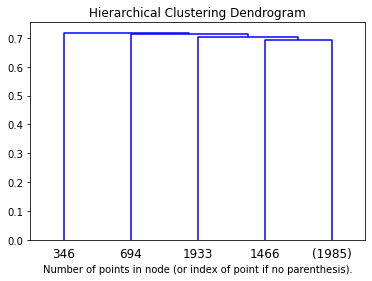

In [65]:

import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


# setting distance_threshold=0 ensures we compute the full tree.
hmodel = AgglomerativeClustering(distance_threshold=0, n_clusters=None,affinity="cosine",linkage="single")

hmodel = hmodel.fit(wvs)
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(hmodel, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [90]:
hmodel = AgglomerativeClustering(n_clusters=200,affinity="cosine",linkage="complete")
hmodel = hmodel.fit(wvs)
words = pd.DataFrame(keys1)
words.columns = ['word']
words.head(10)
words['cluster'] = pd.Series(hmodel.labels_)


In [132]:
#Getting words related to coffee or expresso
expcluster = words[words.word=='expresso'].cluster.to_list()[0]
cofcluster = words[words.word=='coffee'].cluster.to_list()[0]
print(expcluster)
expwords = words.word[words.cluster==expcluster].to_list()
print(expwords)
cofwords = words.word[words.cluster==cofcluster].to_list()
print(cofwords)
cofwords.extend(expwords)

cofcounts = [nouns[word] for word in cofwords]
cofworddf = pd.DataFrame()
cofworddf['word'] = pd.Series(cofwords)
cofworddf['count'] = pd.Series(cofcounts)
cofworddf = cofworddf.sort_values(by=['count'],ascending=False).head(10)
cofworddf

94
['cortado', 'cappuccino', 'americano', 'decaf', 'espresso', 'flat_white', 'expresso', 'macchiato', 'medium', 'red_eye', 'double_shot', 'frap', 'dirty_chai', 'blonde', 'skin', 'venti', 'frappuccino', 'caramel_macchiato', 'pike', 'frapp']
['coffee', 'coffe', 'drink', 'tea', 'java', 'beverage', 'bubble_tea', 'jasmine', 'loose_leaf']


,word,count
0,coffee,20523
2,drink,2189
3,tea,2092
13,espresso,1501
10,cappuccino,892
5,beverage,538
16,macchiato,83
17,medium,83
12,decaf,81
11,americano,68


In [137]:
#Getting words related food or sandwiches
cluster1 = words[words.word=='food'].cluster.to_list()[0]
cluster2 = words[words.word=='sandwich'].cluster.to_list()[0]

words1 = words.word[words.cluster==cluster1].to_list()
words2 = words.word[words.cluster==cluster2].to_list()
words1.extend(words2)

counts = [nouns[word] for word in words1]
worddf = pd.DataFrame()
worddf['word'] = pd.Series(words1)
worddf['count'] = pd.Series(counts)
worddf = worddf.sort_values(by=['count'],ascending=False).head(10)
foodworddf = worddf
foodworddf


,word,count
0,food,4035
12,sandwich,2631
13,egg,1007
29,soup,476
16,chicken,390
18,avocado,365
30,tomato,273
19,salmon,211
25,sauce,174
8,wrap,168


In [139]:
#Getting words related dessert or cookies
cluster1 = words[words.word=='dessert'].cluster.to_list()[0]
cluster2 = words[words.word=='cookie'].cluster.to_list()[0]

words1 = words.word[words.cluster==cluster1].to_list()
words2 = words.word[words.cluster==cluster2].to_list()
words1.extend(words2)

counts = [nouns[word] for word in words1]
worddf = pd.DataFrame()
worddf['word'] = pd.Series(words1)
worddf['count'] = pd.Series(counts)
worddf = worddf.sort_values(by=['count'],ascending=False).head(10)
dessertworddf = worddf
dessertworddf

,word,count
1,pastry,2059
26,matcha,1618
23,cookie,1356
20,croissant,1172
7,cake,1067
6,donut,994
9,dessert,622
0,bakery,490
24,muffin,357
4,treat,307


In [158]:


coflist = cofworddf.word.to_list()
foodlist = foodworddf.word.to_list()
sweetlist = dessertworddf.word.to_list()

coffeeset = set(coflist)
foodset = set(foodlist)
sweetset = set(sweetlist)
coffeeset


{'americano',
 'beverage',
 'cappuccino',
 'coffee',
 'decaf',
 'drink',
 'espresso',
 'macchiato',
 'medium',
 'tea'}

In [204]:
coffeecounts = []
foodcounts = []
sweetcounts = []
#Take words that have similar overall frequencies in the data set. 
#Sum of counts of coffee nouns = sum of counts of food nouns = sum of counts of sweet nouns
for review in reviews[0:5]:
    reviewset = set(review)
    cofcount = len(reviewset.intersection(coffeeset))
    foodcount = len(reviewset.intersection(foodset))
    sweetcount = len(reviewset.intersection(sweetset))
    print(cofcount)
    print(foodcount)
    print(sweetcount)
    coffeecounts.append(cofcount)
    foodcounts.append(foodcount)
    sweetcounts.append(sweetcount)
    
    

1
0
0
1
1
0
1
1
0
0
2
0
1
0
0


In [202]:
print(len(coffeecounts))
print(len(foodcounts))


1207528
21563


0

   labels  counts  dummy
0  coffee       1      1
1  coffee       1      1
2  coffee       1      1
3  coffee       0      1
4  coffee       1      1
                dummy
                count
labels counts        
coffee 0       881480
       1       205845
       2        56711
       3        15133
       4         3812
Index(['category', 'count', 'numreviews'], dtype='object')
  category  count  numreviews
0   coffee      0      881480
1   coffee      1      205845
2   coffee      2       56711
3   coffee      3       15133
4   coffee      4        3812
5   coffee      5        1124
6   coffee      6         270
7   coffee      7          27
8     food      0       16618
9     food      1        3401
21563
21563


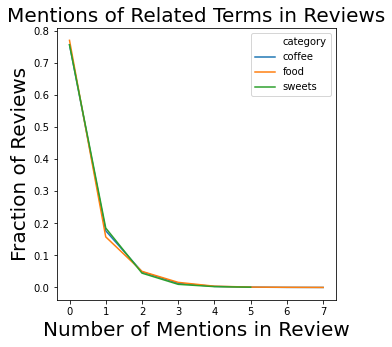

In [197]:
import matplotlib.pyplot as plt
import seaborn as sns
labels = ['coffee' for i in range(len(coffeecounts))]
foodlab = ['food' for i in range(len(foodcounts))]
sweetlab = ['sweets' for i in range(len(sweetcounts))]
labels.extend(foodlab)
labels.extend(sweetlab)

toplot = pd.DataFrame()
toplot['labels'] = pd.Series(labels)
counts = coffeecounts
counts.extend(foodcounts)
counts.extend(sweetcounts)
toplot['counts'] = pd.Series(counts)
toplot['dummy'] = pd.Series([1 for i in range(len(counts))])
print(toplot.head(5))
toplot1 = toplot.groupby(['labels','counts']).agg(['count'])
print(toplot1.head())
toplot1.reset_index(inplace=True)
toplot1.columns = ['category','count','numreviews']
print(toplot1.columns)
print(toplot1.head(10))


cof = toplot1[toplot1.category=='coffee']
cof['freq'] = cof.numreviews/sum(cof.numreviews)

food = toplot1[toplot1.category=='food']
food['freq'] = food.numreviews/sum(food.numreviews)
print(sum(food.numreviews))

sweet = toplot1[toplot1.category=='sweets']
sweet['freq'] = sweet.numreviews/sum(sweet.numreviews)
print(sum(sweet.numreviews))

toplot2 = pd.concat([cof,food,sweet],axis=0)
fig,ax = plt.subplots(1,1,figsize=(5,5))

sns.lineplot(x="count",y="freq",hue="category",data=toplot2,ax=ax)
ax.set_xlabel('Number of Mentions in Review',fontsize=20)
ax.set_ylabel('Fraction of Reviews',fontsize=20)
ax.set_title('Mentions of Related Terms in Reviews',fontsize=20)
fig.savefig('./Figures/coffee_food_sweet_mentions.png',bbox_inches='tight')

In [198]:
food.head(3)

,category,count,numreviews,freq
8,food,0,16618,0.770672
9,food,1,3401,0.157724
10,food,2,1082,0.050179


In [200]:
cof.head(3)

,category,count,numreviews,freq
0,coffee,0,881480,0.757024
1,coffee,1,205845,0.176782
2,coffee,2,56711,0.048704


In [205]:
cof

,category,count,numreviews,freq
0,coffee,0,881480,0.757024
1,coffee,1,205845,0.176782
2,coffee,2,56711,0.048704
3,coffee,3,15133,0.012996
4,coffee,4,3812,0.003274
5,coffee,5,1124,0.000965
6,coffee,6,270,0.000232
7,coffee,7,27,0.000023
